In [104]:
import snntorch as snn
import sys
import os
import platform
import torch
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import pprint as pp

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import itertools
import csv


has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
# device = "mps" if getattr(torch,'has_mps',False) \
#     else "gpu" if torch.cuda.is_available() else "cpu"
device = "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.3.1-arm64-arm-64bit
PyTorch Version: 2.0.0.dev20230210

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is cpu


# Init LIFNet and Netron Class

In [105]:
class Net78x78(nn.Module):
    def __init__(self, config, device, weights=None, biases=None):
        super().__init__()

        self.n_steps = config["sequence_length"]
        self.input_dim = config["input_dim"]
        self.num_classes = config["num_classes"]
        self.device = device

        self.spike_grads = {
            "fast_sigmoid": surrogate.fast_sigmoid(),
            "arctan": surrogate.atan(),
            "LSO": surrogate.LSO(), 
        }

        # Init layers
        self.fc1 = nn.Linear(self.input_dim, self.input_dim)
        # Init fc1.weight with custom_weight
        if weights:
            self.fc1.weight.data = torch.nn.Parameter(torch.from_numpy(weights[0]).float())
            # Init fc1.bias with custom_bias
            self.fc1.bias.data = torch.nn.Parameter(torch.from_numpy(biases[0]).float())

        self.lif1 = snn.Leaky(beta=config['beta'], spike_grad=self.spike_grads[config['surrogate']]) # learn beta to implement on Netron

        self.fc2 = nn.Linear(self.input_dim, config['hid_layers'][0])
        # Init fc2.weight with custom_weight
        if weights:
            self.fc2.weight.data = torch.nn.Parameter(torch.from_numpy(weights[1]).float())
            # Init fc2.bias with custom_bias
            self.fc2.bias.data = torch.nn.Parameter(torch.from_numpy(biases[1]).float())

        self.lif2 = snn.Leaky(beta=config['beta'], spike_grad=self.spike_grads[config['surrogate']])

        self.lif_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()

        # Create hiden layers with LIF neurons
        for i in range(len(config['hid_layers'])-1):
            self.fc_layers.append(nn.Linear(config['hid_layers'][i], config['hid_layers'][i+1]))
            # Init fc_layers[i].weight with custom_weight
            if weights:
                self.fc_layers[i].weight.data = torch.nn.Parameter(torch.from_numpy(weights[i+2]).float())
                # Init fc_layers[i].bias with custom_bias
                self.fc_layers[i].bias.data = torch.nn.Parameter(torch.from_numpy(biases[i+2]).float())
            self.lif_layers.append(snn.Leaky(beta=config['beta'], spike_grad=self.spike_grads[config['surrogate']]))

        # Final layer
        self.fc_final = nn.Linear(config['hid_layers'][-1], self.num_classes)
        # Init fc_final.weight with custom_weight
        if weights:
            self.fc_final.weight.data = torch.nn.Parameter(torch.from_numpy(weights[-1]).float())
            # Init fc_final.bias with custom_bias
            self.fc_final.bias.data = torch.nn.Parameter(torch.from_numpy(biases[-1]).float())
        self.lif_final = snn.Leaky(beta=config['beta'], threshold=config['out_threshold'], spike_grad=self.spike_grads[config['surrogate']])

        self.dropout = nn.Dropout(p=config["dropout"])
       
    def forward(self, x):
        # Init hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_layers = [lif_layer.init_leaky() for lif_layer in self.lif_layers]
        mem_final = self.lif_final.init_leaky()

        # Record the final layer
        spk_final_rec = []
        mem_final_rec = []

        for step in range(self.n_steps):
            cur = self.fc1(x[step])
            spk, mem1 = self.lif1(cur, mem1)

            cur = self.fc2(spk)
            spk, mem2 = self.lif2(cur, mem2)

            for i in range(len(self.fc_layers)):
                cur = self.fc_layers[i](spk)
                cur = self.dropout(cur)
                spk, mem_layers[i] = self.lif_layers[i](cur, mem_layers[i])

            cur = self.fc_final(spk)
            cur = self.dropout(cur)
            spk_final, mem_final = self.lif_final(cur, mem_final)

            spk_final_rec.append(spk_final)
            mem_final_rec.append(mem_final)

        return torch.stack(spk_final_rec, dim=0), torch.stack(mem_final_rec, dim=0)
    
    def forward_with_rec(self, x):
        # Init hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_layers = [lif_layer.init_leaky() for lif_layer in self.lif_layers]
        mem_final = self.lif_final.init_leaky()

        # Record layer activity
        mem1_rec = []
        spk1_rec = []
        mem2_rec = []
        spk2_rec = []
        spk_layers_rec = [[] for _ in range(len(self.lif_layers))]
        mem_layers_rec = [[] for _ in range(len(self.lif_layers))]
        spk_final_rec = []
        mem_final_rec = []

        for step in range(self.n_steps):
            cur = self.fc1(x[step])
            spk, mem1 = self.lif1(cur, mem1)
            spk1_rec.append(spk)
            mem1_rec.append(mem1)
            
            cur = self.fc2(spk)
            spk, mem2 = self.lif2(cur, mem2)
            spk2_rec.append(spk)
            mem2_rec.append(mem2)

            for i in range(len(self.fc_layers)):
                cur = self.fc_layers[i](spk)
                spk, mem_layers[i] = self.lif_layers[i](cur, mem_layers[i])
                spk_layers_rec[i].append(spk)
                mem_layers_rec[i].append(mem_layers[i])

            cur = self.fc_final(spk)
            spk_final, mem_final = self.lif_final(cur, mem_final)

            spk_final_rec.append(spk_final)
            mem_final_rec.append(mem_final)

        # spk_layers_rec = [torch.stack(spk_rec, dim=0) for spk_rec in spk_layers_rec]
        # mem_layers_rec = [torch.stack(mem_rec, dim=0) for mem_rec in mem_layers_rec]

        # zip each recording list in spk and mem together as pairs
        rec_list = [[torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)], [torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)]]
        rec_list.extend([[torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)] for spk_rec, mem_rec in zip(spk_layers_rec, mem_layers_rec)])
        rec_list.append([torch.stack(spk_final_rec, dim=0), torch.stack(mem_final_rec, dim=0)])

        return rec_list

    
    def visualize_all_neurons(self, x):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        for i, (layer_output, layer_state) in enumerate(layers_hist):
            layer_state, layer_output = layer_state.cpu().numpy().squeeze().transpose(), layer_output.cpu().numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
        # print(len(layers_hist), len(layers_hist[0]))
 
        # layer_state, layer_output = layers_hist[layer_idx]
        layer_state, layer_output = layers_hist[layer_idx][1].cpu().numpy().squeeze().transpose(), layers_hist[layer_idx][0].cpu().numpy().squeeze().transpose() # (activity, time) i think
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
       
        fig, ax = plt.subplots(figsize=(16, 4))
        im = ax.pcolormesh(layer_values, cmap='rainbow')
        plt.title(title)
        plt.colorbar(im, ax=ax)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")

        # Set y-axis ticks to integer values
        if layer_values.shape[0] < 10:
            ticks = np.arange(0, layer_values.shape[0]+1, 1)
            ax.set_yticks(ticks)
        else:
            ticks = np.arange(0, layer_values.shape[0]+1, int(layer_values.shape[0]/10))
            ax.set_yticks(ticks)

        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        plt.figure(figsize=(16, 4))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")

        # add the voltage threshold by accessing state_dict of the leaky neuron
        plt.axhline(y=self.lif1.threshold.cpu(), color='r', linestyle='-')

        plt.show()

class Netron():
    def __init__(self, config, device, from_wnb=False):
        
        self.model_path = config['model_path']
        self.edm_thr_path = config['EDM_thr_path']
        self.device = device
        if from_wnb:
            self.load_wnb(config['config_path'], config['wnb_path'])
        else:
            self.load_model()
        self.load_EDM_thr()

    def load_model(self):
        checkpoint = torch.load(self.model_path, map_location=self.device)
        self.model_config = checkpoint['config']
        self.model = Net78x78(self.model_config, self.device)
        self.state_dict = checkpoint['model_state']
        self.model.load_state_dict(self.state_dict)
        self.model.eval()

    def load_wnb(self, config_path, wnb_path):
        with open(config_path, 'rb') as f:
            self.model_config = pickle.load(f)
        with open(wnb_path, 'rb') as f:
            weights, biases = pickle.load(f)
        self.model = Net78x78(self.model_config, self.device, weights=weights, biases=biases)

    def load_EDM_thr(self):
        with open (self.edm_thr_path, 'rb') as f:
            self.ch_ref = pickle.load(f)
            self.edm_thr = {k: v['edm_thresholds'] for k, v in self.ch_ref.items()}

    def forward_pass_e2e(self, input, *args, **kwargs):
        edm_spiketrains = self.forward_pass_EDM(input, *args, **kwargs)
        spk_rec, mem_rec = self.forward_pass_SNN(edm_spiketrains)
        return spk_rec, mem_rec, edm_spiketrains

    def forward_pass_EDM(self, input, drop_ch=None):
        edm_output = self.edm_vec(input)  # (n_alpha, n_samples, n_channels)
        edm_output = np.moveaxis(edm_output, [2, 0], [0, 1])  # (n_channels, n_alpha, n_samples)
        edm_spiketrains = np.zeros(input.shape)

        for i, ch in enumerate(self.edm_thr):
            condition1 = (self.edm_thr[ch][0] < edm_output[i, 0]) & (edm_output[i, 0] < self.edm_thr[ch][1]) # 1 - 4 comparators 
            condition2 = (self.edm_thr[ch][2] < edm_output[i, 1]) & (edm_output[i, 1] < self.edm_thr[ch][3])
            st = condition1 & condition2 # final andgate 
            # use a nand gate instead
            # st = ~(condition1 & condition2)
            edm_spiketrains[st, i] = 1 
        
        if drop_ch:
            edm_spiketrains = np.delete(edm_spiketrains, list(map(self.idx_translate, drop_ch)), axis=1)

        return edm_spiketrains
                               
    def forward_pass_SNN(self, input):
        # input to this function will be the output of forward_pass_EDM
        # convert to tensor and unsqueeze to add batch dimension
        input = torch.from_numpy(input).unsqueeze(0).float().permute(1, 0, 2) # (n_samples, batch_size, n_channels)
        spk_rec, mem_rec = self.model.forward(input)

        return spk_rec, mem_rec 

    def edm_vec(self, x, alphas=[1, 3], init_edm=0.5):
        n_alpha = len(alphas)
        edm_output = np.zeros((n_alpha, x.shape[0], x.shape[1])) # (n_alpha, n_samples, n_channels)
        edm = np.ones((n_alpha, x.shape[1])) * init_edm
        alphas = np.array([1/2**a for a in alphas]).reshape(-1, 1)

        for t in range(x.shape[0]):
            edm = edm - alphas * (edm - x[t, :].reshape(1, -1))
            edm_output[:, t, :] = edm
        
        return edm_output
    
    def idx_translate(self, ch_id):
       return list(self.ch_ref.keys()).index(ch_id)
    
    def plot_activity(self, x, y):
        '''
        expects output of forward_pass_EDM
        '''
        with torch.no_grad():
            x = torch.from_numpy(x).unsqueeze(1).float() # (batch_size, n_samlpes, n_channels)

            self.model.plot_layer(x.squeeze().cpu().numpy().transpose(), title="Input activity")
            self.model.visualize_all_neurons(x)
            # output neuron of correct label
            print('Correct label: ', y)
            self.model.visualize_neuron(x, layer_idx=-1, neuron_idx=y)

            # output neuron of incorrect label
            print('Incorrect label: ', 1-y)
            self.model.visualize_neuron(x, layer_idx=-1, neuron_idx=1-y)
    
    

       


# Load Dataset

In [81]:
loaded = np.load('./dataset/ap_dset.npz')
X, Y, markers = loaded['X'], loaded['Y'], loaded['markers']

markers = markers.astype(int)

loaded_test = np.load('./dataset/test_set_ap.npz')
X_test, Y_test = loaded_test['X'], loaded_test['Y'], 




## SKIP FOR INF

In [100]:
netron_config = {
    'model_path': './models/edm1driven_best/final_ngc536dn.pth',
    'EDM_thr_path': './dataset/EDMNet_liberal_thresholds_edm1driven.pkl', 
}

netron = Netron(netron_config, device)


In [83]:
# create 2 lists for weights and biases -> convert to numpy arrays
weights = []
for name, param in netron.model.named_parameters():
    if 'weight' in name:
        weights.append(param.data.numpy())

print(len(weights))

biases = []
for name, param in netron.model.named_parameters():
    if 'bias' in name:
        biases.append(param.data.numpy())

print(len(biases))

3
3


In [84]:
for i in range(len(weights)):
    print("Layer", i, ":", weights[i].shape, biases[i].shape)



Layer 0 : (73, 73) (73,)
Layer 1 : (256, 73) (256,)
Layer 2 : (2, 256) (2,)


In [85]:
pp.pprint(netron.model_config)

{'X_shape': (142, 3000, 73),
 'aug_dynamic': None,
 'aug_prob': 0.4,
 'aug_strategy': 'single',
 'aug_trials': 1000,
 'augmented': None,
 'batch_size': 8,
 'beta': 0.9,
 'classes': {'PG': 0, 'SG': 1},
 'dropout': 0.0,
 'dset': 'edm1driven_dropped',
 'enable_wandb': True,
 'grad_clip': None,
 'grad_mask': True,
 'hid_layers': [256],
 'input_dim': 73,
 'loss': 'CECountLoss',
 'lr': 0.0005,
 'lr_scheduler': 'none',
 'n_electrodes': 73,
 'name': 'edm1driven_2152',
 'num_classes': 2,
 'num_epochs': 200,
 'optimizer': 'Adam',
 'out_threshold': 1.0,
 'overfit_minibatch': False,
 'project': 'lif_params',
 'save_model_threshold': 0.0,
 'sequence_length': 3000,
 'surrogate': 'arctan',
 'test_dataset_size': 15,
 'test_minibatch_size': 2,
 'test_split': 0.1,
 'train_dataset_size': 127,
 'train_minibatch_size': 16,
 'unique': True,
 'weight_decay': 0,
 'weight_init': 'even_78x78',
 'workers': 0}


In [86]:
# export model config as pickle
with open('./models/pickles/model_config_inf.pkl', 'wb') as f:
    pickle.dump(netron.model_config, f)

In [87]:
# export weights and biases as a pickle 
with open('./models/pickles/wnb_inf.pkl', 'wb') as f:
    pickle.dump((weights, biases), f)

# START FROM HERE AFTER DSET LOAD

In [106]:
netron_config = {
    'model_path': './models/edm1driven_best/final_ngc536dn.pth',
    'EDM_thr_path': './dataset/EDMNet_liberal_thresholds_edm1driven.pkl', 
    # 'state_path': './models/pickles/state_dict_inf.pkl',
    'config_path': './models/pickles/model_config_inf.pkl',
    'wnb_path': './models/pickles/wnb_inf.pkl',
}

netron = Netron(netron_config, device, from_wnb=True)

# Calculate EDM

In [107]:
trial = 10
sample_X = X[trial]
sample_Y = Y[trial]
print(sample_X.shape)
edm_X = netron.edm_vec(sample_X)
print(edm_X.shape)

(3000, 78)
(2, 3000, 78)


In [108]:
drop_ch = [11, 33, 26, 58, 18]
edm_spiketrain_X = netron.forward_pass_EDM(sample_X, drop_ch=drop_ch)
print(edm_spiketrain_X.shape)
print(np.sum(edm_spiketrain_X))


(3000, 73)
324.0


# Forward Pass Plots

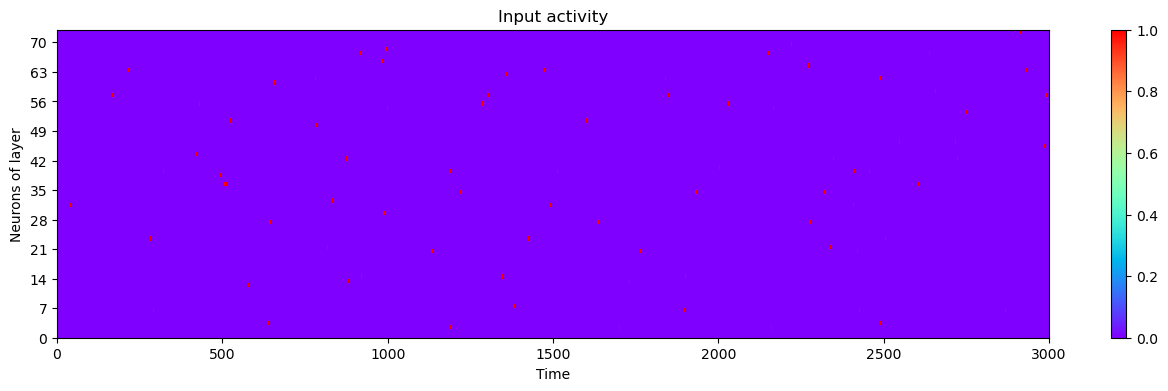

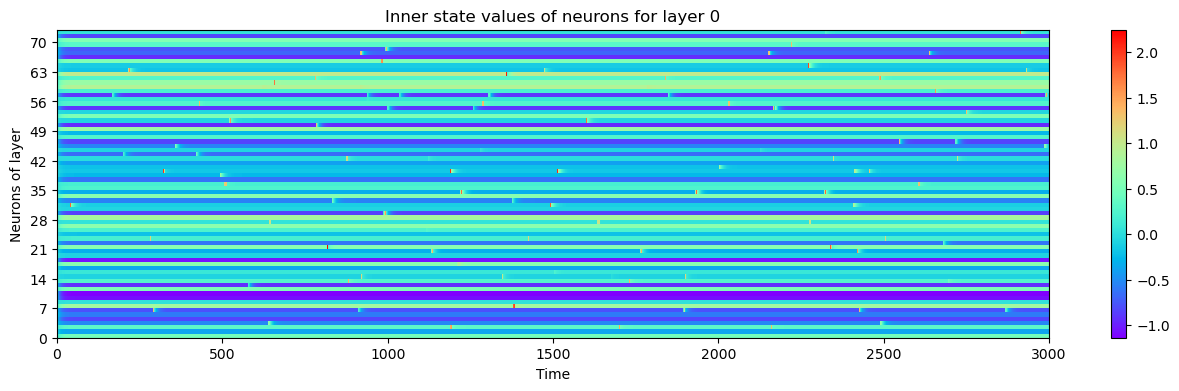

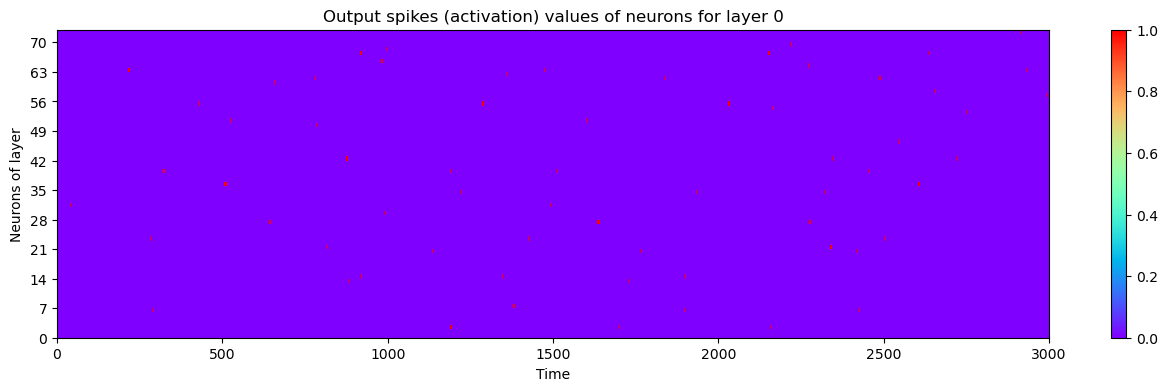

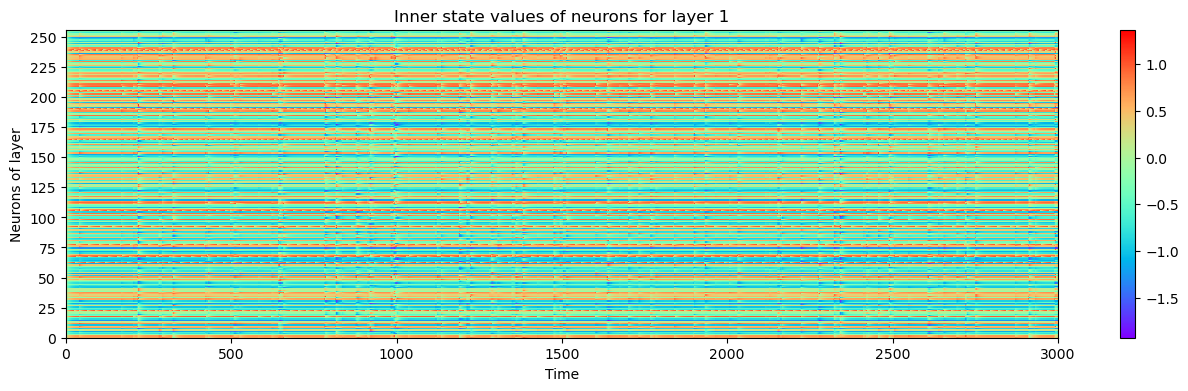

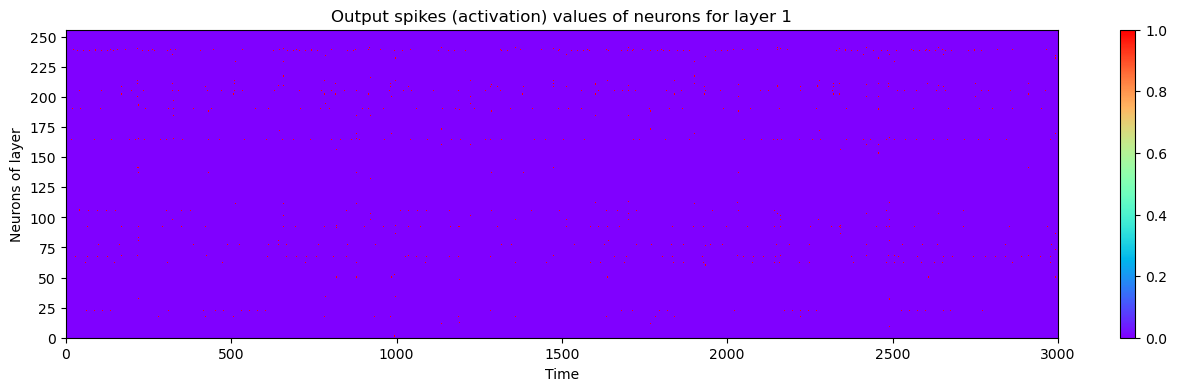

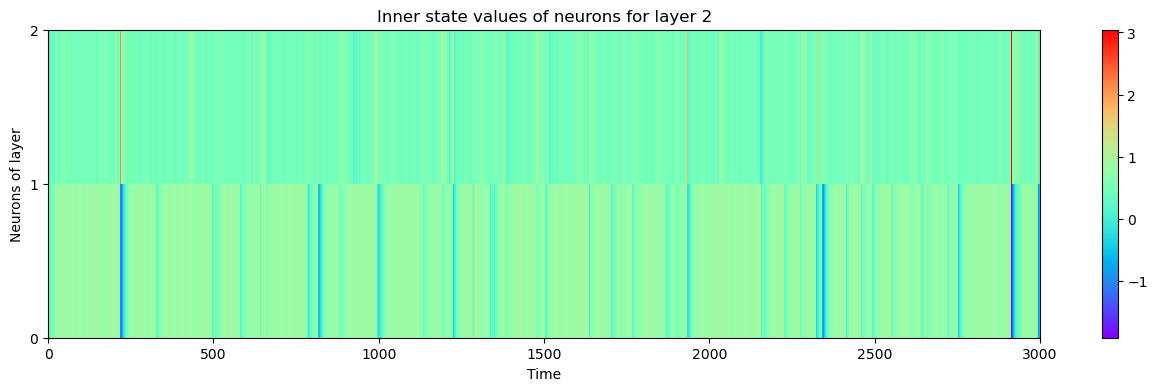

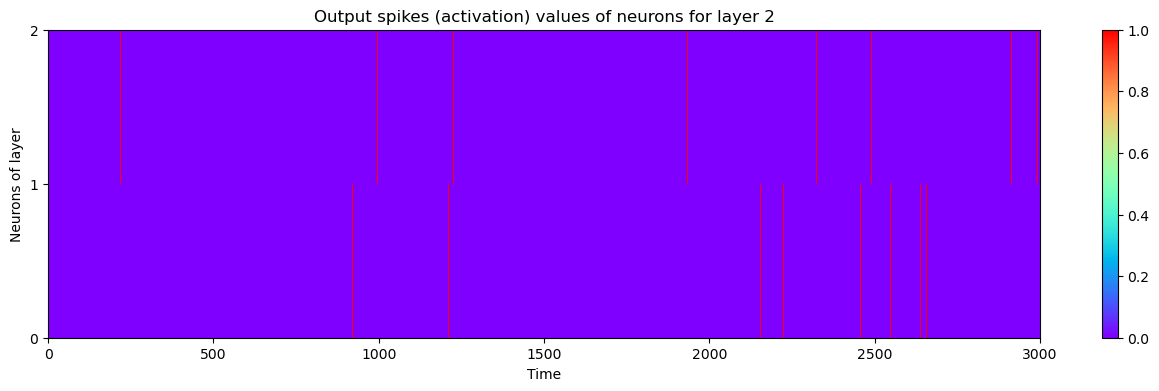

Correct label:  1


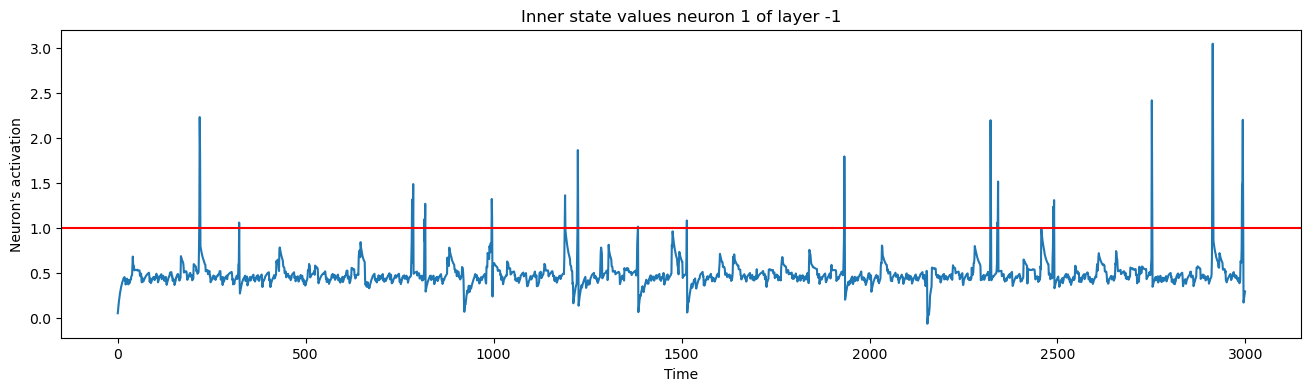

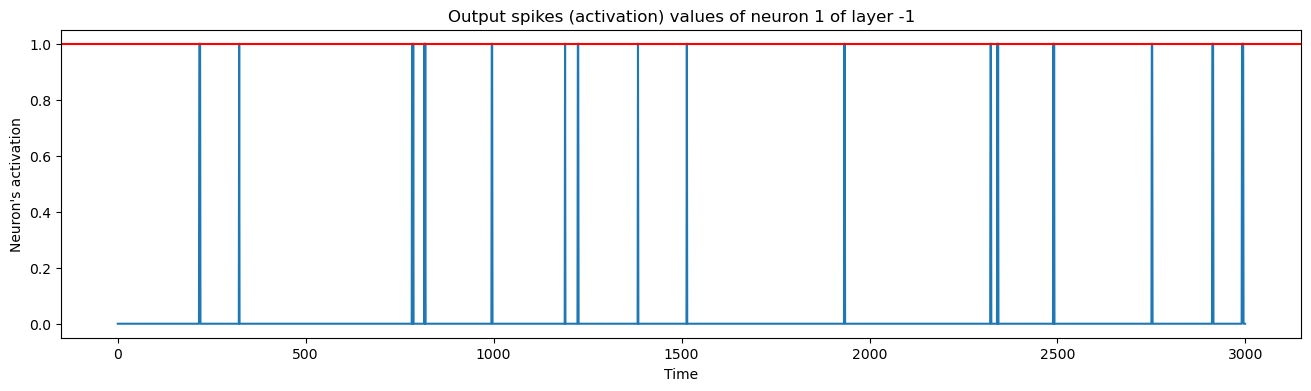

Incorrect label:  0


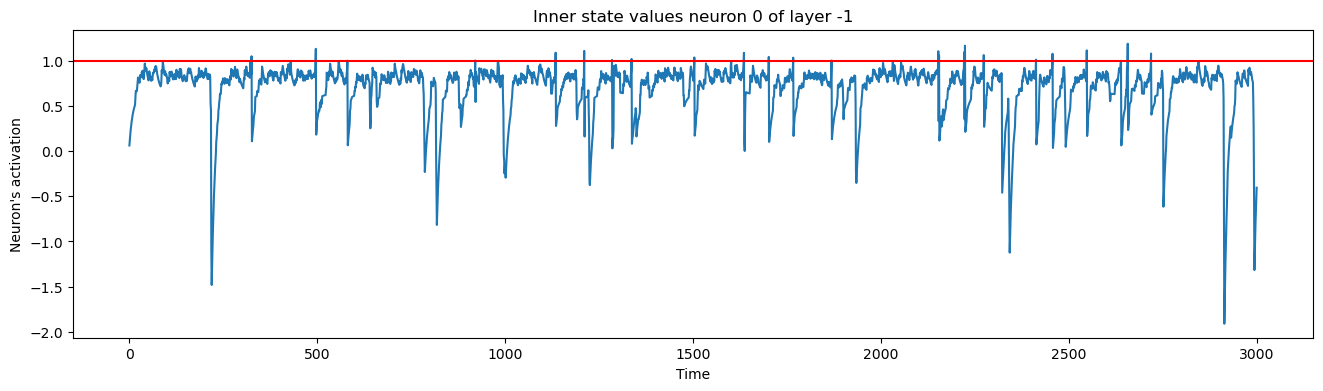

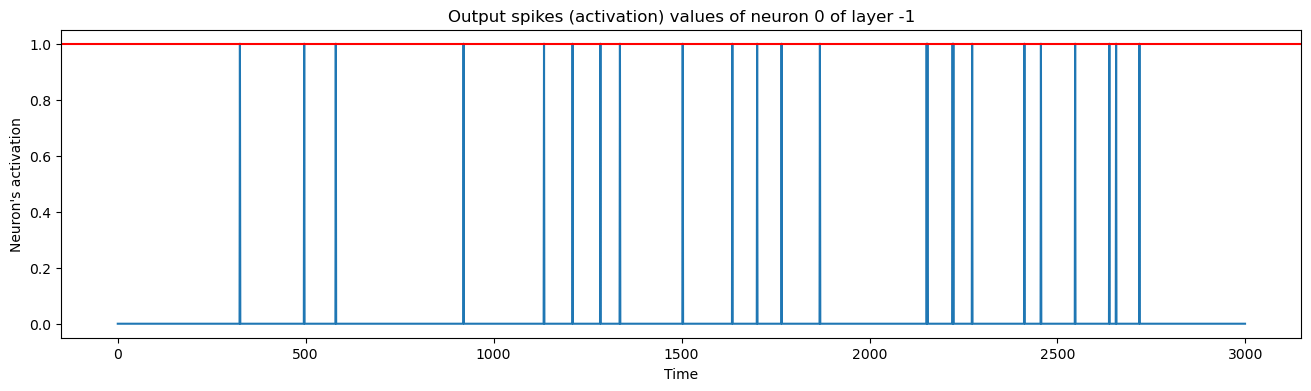

In [110]:
netron.plot_activity(edm_spiketrain_X, sample_Y)

# Test End2End Forward Pass

In [109]:
spk_rec, mem_rec, edm_spiketrains = netron.forward_pass_e2e(sample_X, drop_ch=drop_ch)

print("Spike recording: ", spk_rec.shape)
print("Membrane potential recording: ", mem_rec.shape)
print("EDM spike trains: ", edm_spiketrains.shape)
print("out spk sum: ", sum(spk_rec))

Spike recording:  torch.Size([3000, 1, 2])
Membrane potential recording:  torch.Size([3000, 1, 2])
EDM spike trains:  (3000, 73)
out spk sum:  tensor([[24., 32.]], grad_fn=<AddBackward0>)
